## 预测多个值

In [ ]:
import csv
import numpy as np
import torch
import matplotlib.pyplot as plt 
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error
# 链接了多个 OpenMP 运行时库，解决
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from torch.utils.tensorboard import SummaryWriter
# tensorboard 
writer = SummaryWriter()


In [9]:
# 数据及加载
with open('./weather_dataset/Summary of Weather.csv', 'r', encoding='utf-8') as f:
    data = csv.DictReader(f)
    temperatures = [float(row['MaxTemp']) for row in data]

temperatures = np.array(temperatures, dtype=np.float32)
temperatures = np.round(temperatures, 0)

# 数据集拆分
n_steps = 5
temperatures = temperatures[:10000* (n_steps + 5)* 1]
series = temperatures.reshape(10000, n_steps + 5, 1)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -5:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -5:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -5:, 0]
print(X_train[0,0:10])
X_train.shape, Y_train.shape

[[26.]
 [29.]
 [26.]
 [27.]
 [27.]]


((7000, 5, 1), (7000, 5))

In [ ]:


def plot_series(series, y=None, y_pred=None, y_pred_std=None, x_label="$t$", y_label="$x$"):
    # 设置行数和列数
    r, c = 3, 5
    # 创建子图
    fig, axes = plt.subplots(nrows=r, ncols=c, sharey=True, sharex=True, figsize=(20, 10))
    # 遍历每一行
    for row in range(r):
        # 遍历每一列
        for col in range(c):
            # 设置当前子图
            plt.sca(axes[row][col])
            # 计算当前子图的索引
            ix = col + row*c
            # 绘制原始序列
            plt.plot(series[ix, :], ".-")
            # 如果有真实值，绘制真实值
            if y is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y[ix])), y[ix], "bx", markersize=10)
            # 如果有预测值，绘制预测值
            if y_pred is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix], "ro")
            # 如果有预测值的标准差，绘制预测值的上下界
            if y_pred_std is not None:
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] + y_pred_std[ix])
                plt.plot(range(len(series[ix, :]), len(series[ix, :])+len(y_pred[ix])), y_pred[ix] - y_pred_std[ix])
            # 显示网格线
            plt.grid(True)
            # 绘制水平线
            plt.hlines(0, 0, 100, linewidth=1, colors='red')
            # 设置坐标轴范围
            plt.axis([0, len(series[ix, :])+len(y[ix]), -20, 40])
            # 如果有x轴标签，设置x轴标签
            if x_label and row == r - 1:
              plt.xlabel(x_label, fontsize=16)
            # 如果有y轴标签，设置y轴标签
            if y_label and col == 0:
              plt.ylabel(y_label, fontsize=16, rotation=0)
    # 显示图像
    plt.show()

plot_series(X_test, Y_test)

NameError: name 'y_test' is not defined

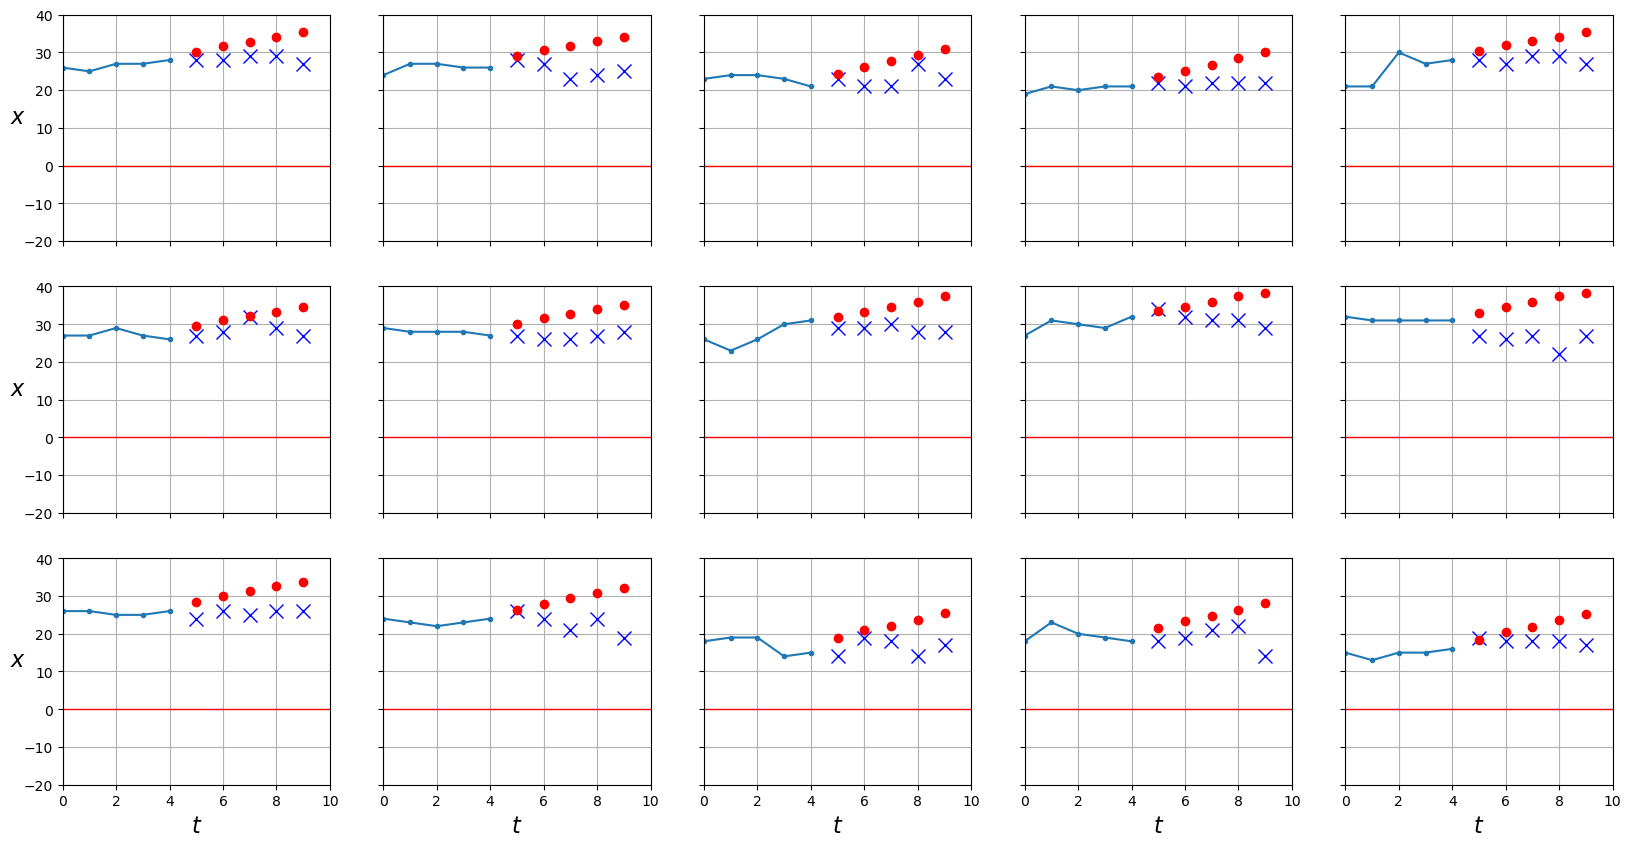

44.516746520996094

In [ ]:

X = X_test
for step_ahead in range(5):
    inputs = torch.from_numpy(X[:, step_ahead:]).unsqueeze(0)
    y_pred_one = predict(rnn, inputs).cpu().numpy()
    X = np.concatenate([X, y_pred_one[:, np.newaxis, :]], axis=1)

y_pred = X[:, n_steps:, -1]
plot_series(X_test, Y_test, y_pred)
mean_squared_error(Y_test, y_pred)

In [ ]:
class DeepRNN(torch.nn.Module):
  def __init__(self, n_out=5):
    super().__init__()
    self.rnn = torch.nn.RNN(input_size=1, hidden_size=100, num_layers=5, batch_first=True)
    self.fc = torch.nn.Linear(100, n_out)

  def forward(self, x):
    x, h = self.rnn(x) 
    x = self.fc(x[:,-1])
    return x

In [ ]:
rnn = DeepRNN()
fit(rnn, dataloader)

  0%|          | 0/20 [00:00<?, ?it/s]d:\SoftwareLocation\anaconda3\envs\DeepLearning\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([64, 1])) that is different to the input size (torch.Size([64, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\SoftwareLocation\anaconda3\envs\DeepLearning\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([24, 1])) that is different to the input size (torch.Size([24, 5])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
d:\SoftwareLocation\anaconda3\envs\DeepLearning\Lib\site-packages\torch\nn\modules\loss.py:610: UserWarning: Using a target size (torch.Size([16, 1])) that is different to the input size (torch.Size([16, 5])). This

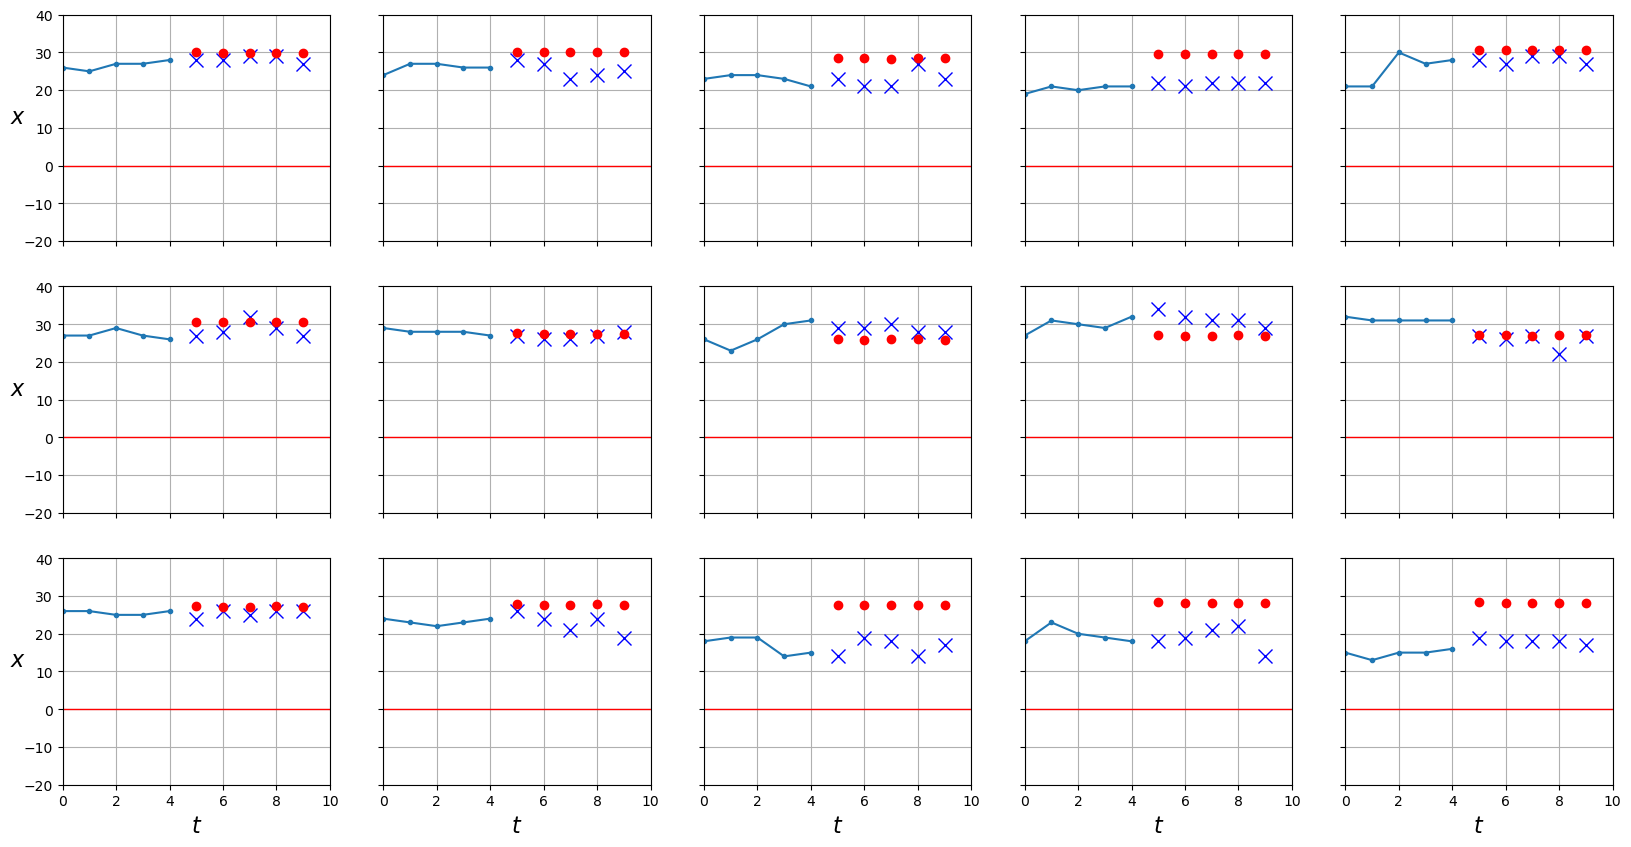

92.24040222167969

In [ ]:
y_pred = predict(rnn, dataloader['test'])
plot_series(X_test, Y_test, y_pred.cpu().numpy())
mean_squared_error(Y_test, y_pred.cpu())